In [1]:
import sys
sys.path.append('..')

In [2]:
from pymavlink import mavutil

import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

In [3]:
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [4]:
RUTA_COMPLETA

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [5]:
vehiculo = 'DA01'

In [6]:
path_rec = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\RECORRIDOS_.shp'
gdf_rec = gpd.read_file(path_rec)

In [7]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

95

In [8]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

3

In [9]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [10]:
lineas, names = leer_logs(contenido_filtrado)

In [11]:
lineas

[<LINESTRING (-63.185 -17.023, -63.185 -17.023, -63.185 -17.023, -63.185 -17....>,
 <LINESTRING (-63.216 -17.032, -63.216 -17.032, -63.216 -17.032, -63.216 -17....>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>]

In [12]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")

In [13]:
gdf_lines.head(3)

,nombre,geometry
0,2025-09-04 00-15-24.tlog,"LINESTRING (-63.18493 -17.02292, -63.18493 -17..."
1,2025-09-04 00-50-23.tlog,"LINESTRING (-63.21595 -17.03215, -63.21595 -17..."
2,2025-09-04 13-04-45.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."


<Axes: >

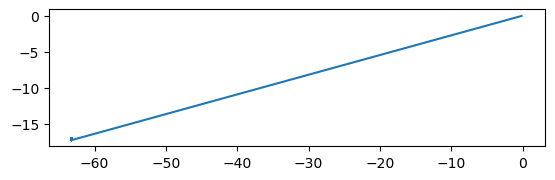

In [14]:
gdf_lines.plot()

In [15]:
gdf_lines.to_file('LINEAS.shp', driver="ESRI Shapefile")

In [16]:
# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [17]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [18]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [19]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [20]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)

In [21]:
gdf_lines['vehiculo'] = vehiculo

In [22]:
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-09-04 00-15-24.tlog,"LINESTRING (-63.18493 -17.02292, -63.18493 -17...",3156,DA01
1,2025-09-04 00-50-23.tlog,"LINESTRING (-63.21595 -17.03215, -63.21595 -17...",1555,DA01
2,2025-09-04 13-04-45.tlog,"LINESTRING (-63.19783 -17.24030, -63.19783 -17...",798,DA01


<Axes: >

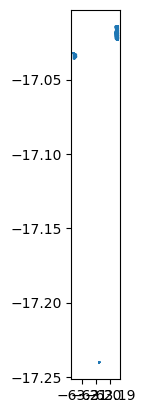

In [23]:
gdf_lines.plot()

In [24]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

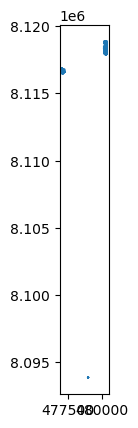

In [25]:
gdf_lines_utm.plot()

In [26]:
# Combinar los GeoDataFrames
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_rec, gdf_lines_utm], ignore_index=True))
# rellenar valores NaN
gdf_combined['idd'] = gdf_combined['idd'].fillna(0).astype(int)

In [27]:
gdf_combined

,idd,nombre,vehiculo,num_vert,id,asignado,geometry
0,-1,2025-05-02 08-32-28.tlog,DA02,2517.0,None,ORIGINAL,"LINESTRING (471873.745 8084797.248, 471873.415..."
1,-1,2025-05-05 16-16-47.tlog,DA02,1056.0,None,ORIGINAL,"LINESTRING (478886.299 8093597.535, 478886.288..."
2,-1,2025-05-05 16-32-05.tlog,DA02,345.0,None,ORIGINAL,"LINESTRING (478939.004 8093577.919, 478939.004..."
3,-1,2025-05-05 21-05-04.tlog,DA02,3426.0,None,ORIGINAL,"LINESTRING (478661.660 8093836.724, 478660.405..."
4,-1,2025-05-05 21-05-04.tlog,DA02,3207.0,None,ORIGINAL,"LINESTRING (478649.523 8093832.840, 478649.555..."
...,...,...,...,...,...,...,...
407,0,2025-09-03 05-19-37.tlog,DA02,1584.0,None,None,"LINESTRING (488607.983 8103762.439, 488607.983..."
408,0,2025-09-03 14-07-21.tlog,DA02,2612.0,None,None,"LINESTRING (487668.342 8103744.808, 487668.342..."
409,0,2025-09-04 00-15-24.tlog,DA01,3156.0,NaN,NaN,"LINESTRING (480317.509 8117900.680, 480317.530..."
410,0,2025-09-04 00-50-23.tlog,DA01,1555.0,NaN,NaN,"LINESTRING (477017.780 8116875.226, 477017.780..."


In [28]:
gdf_combined.dtypes

idd            int32
nombre        object
vehiculo      object
num_vert     float64
id            object
asignado      object
geometry    geometry
dtype: object

In [29]:
gdf_combined.to_file(path_rec, driver="ESRI Shapefile")